In [1]:
%matplotlib inline

In [2]:
import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from Application.server import fake_connection
import cv2

ModuleNotFoundError: No module named 'server'

Gather the contour points according to a min and max thresh for the area of contours.

In [ ]:
def get_contours(frame, t1, t2, retrieval=cv2.RETR_TREE, approx=cv2.CHAIN_APPROX_NONE):
    # blurred = cv2.GaussianBlur(frame, (7, 7), 2)
    # gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    # canny = cv2.Canny(gray, t1, t2)
    # kernel = np.ones((5,5))
    # dilated = cv2.dilate(canny, kernel, iterations=1)
    dilated = cv2.threshold(frame, 127, 255, cv2.THRESH_TRUNC)
    contours, _ = cv2.findContours(dilated, retrieval, approx)
    return contours

THRESH1 = 96
THRESH2 = 140
CONTOUR_MIN = 756
CONTOUR_MAX = 2277

frame_width = None
frame_hight = None

gathering_points = True
all_contours = None
max_points = 100000

# While number of points collects is insufficient
while gathering_points:
    for file, frame in fake_connection():
        
        # Saved frame dimensions
        if frame_width is None:
            frame_height, frame_width, _ = frame.shape

        # Apply open cv2 image transmformations for contour detection
        contours = get_contours(frame, THRESH1, THRESH2)

        for contour in contours:

            # Filter by min and max areas of contours
            area = cv2.contourArea(contour)
            if area > CONTOUR_MIN and area < CONTOUR_MAX:

                # Init np.array for all_contours
                if all_contours is None: all_contours = np.array(contour)

                else:
                    if len(all_contours) >= max_points:
                        gathering_points = False
                        break
                    
                    else:
                        all_contours = np.append(all_contours, contour, axis=0)
        
        if not gathering_points: break

drawable = all_contours
all_contours = all_contours.reshape((-1, 2))

Given the list of all points gathered, perform Kmeans clustering

In [ ]:
def find_closest_centroid(X, centroids):

    K = centroids.shape[0]
    m, n = X.shape

    indices = np.zeros(m, dtype=int)

    # For each point
    for i in range(m):
        distances = []

        # For each centroids
        for j in range(K):

            # Calc distance
            norm = np.linalg.norm(X[i] - centroids[j], axis=0)
            distances.append(norm)

        # Save min distance to current point
        indices[i] = np.argmin(distances)

    return indices

def update_centroid(X, indicies, K):
    m, n = X.shape
    new_centroids = []

    # For each centroid
    for k in range(K):

        # Find all points bound to the current centroid
        points = X[indicies==k]

        # If there is at least one point
        if len(points) != 0:
            new_centroids.append(np.mean(points, axis=0))
    return np.array(new_centroids)

centroids = []
width_bins = 4
height_bins = 4
x_diff = frame_width // width_bins
y_diff = frame_height // height_bins
curr_y = y_diff
for _ in range(height_bins-1):
    curr_x = x_diff
    for _ in range(width_bins-1):
        centroids.append([curr_x, curr_y])
        curr_x += x_diff
    curr_y += y_diff
centroids = np.array(centroids)

history = []
m, n = all_contours.shape


indicies = np.zeros(m)
max_iter = 5

for i in range(max_iter):
    K = len(centroids)
    print(f"\n\nK-Means Iteration ({i}) / ({max_iter})")
    indicies = find_closest_centroid(all_contours, centroids)
    # print(np.unique(indicies))
    history.append(centroids)
    centroids = update_centroid(all_contours, indicies, K)




K-Means Iteration (0) / (5)


K-Means Iteration (1) / (5)


K-Means Iteration (2) / (5)


K-Means Iteration (3) / (5)


K-Means Iteration (4) / (5)


Show found centroid positions and contours

Displaying 9 centroids


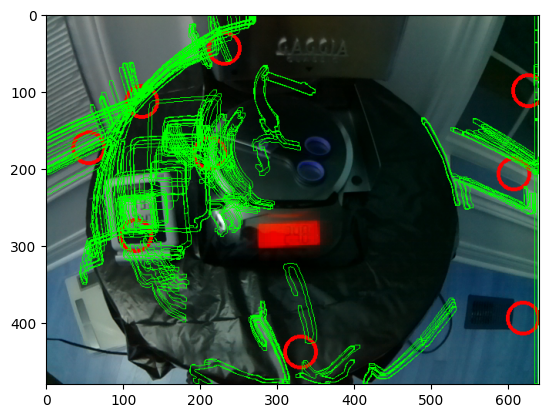

In [ ]:

print(f"Displaying {len(centroids)} centroids")

frame_copy = frame.copy()
for centroid in centroids:
    centroid = tuple(np.uint32(centroid))
    cv2.circle(frame_copy, centroid, 20, (255, 0, 0), 3)

cv2.drawContours(frame_copy, drawable, -1, (0, 255, 0), 1)
plt.figure()
plt.imshow(frame_copy)

Go through all sensor guesses (centroids) and check if there they contain digits

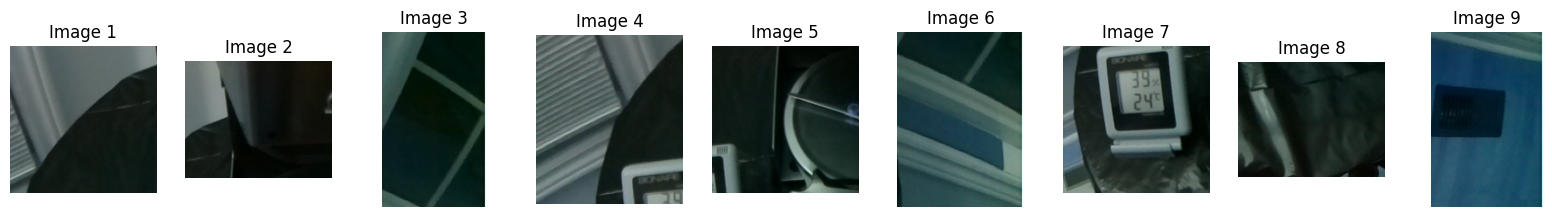

In [ ]:
sensor_frame_width = 150
sensor_frame_height = 150

assumed_sensors = []

for centroid in centroids:
    centroid_x, centroid_y = tuple(np.uint32(centroid))
    x1 = max(centroid_x - sensor_frame_width//2, 0)
    x2 = min(centroid_x + sensor_frame_width//2, frame_width)
    y1 = max(centroid_y - sensor_frame_height//2, 0)
    y2 = min(centroid_y + sensor_frame_height//2, frame_height)

    subframe = frame[y1:y2, x1:x2]

    # contours = get_contours(subframe, THRESH1, THRESH2, retrieval=cv2.RETR_LIST)
    # for contour in contours:
        # cv2.drawContours(subframe, contour, -1 ,(0, 255, 255), 2)
        # peri = cv2.arcLength(contour, True)
        # approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        
        
    assumed_sensors.append(subframe)


rows = 2
columns = len(assumed_sensors)
fig = plt.figure(figsize=(20,5))
for i in range(len(assumed_sensors)):
    sensor = assumed_sensors[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sensor)
    plt.axis("off")
    plt.title(f"Image {i+1}")

# altered = []
# for img in assumed_sensors:
#     rtn, threshed = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
#     altered.append(threshed)

# for i in range(len(altered)):
#     img = altered[i]
#     fig.add_subplot(rows, columns, i+1)
#     plt.imshow(img)
#     plt.axis("off")
    # plt.title(f"Temp {i+1}")


plt.show()